# Plan
- Dataset + transformations
- Dataloader
- Architecture
- Optimizer, loss, metric
- Training

# Importing packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [2]:
class Dataset2Class(torch.utils.data.Dataset):
    def __init__(self, path_dir1: str, path_dir2: str):
        super().__init__
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
    
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        if idx < len(self.dir1_list):
            class_id = 0 
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else: 
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        #img = (img[:,:,0:1]+img[:,:,1:2]+img[:,:,2:3])/3 - if we want to make the image black and white
       
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        img = img.transpose(2,0,1) # put the length, width, channels in the right place
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
        return {'img': t_img, 'label': t_class_id}

In [3]:
train_dogs_path = './dataset/train/dogs/'
train_cats_path = './dataset/train/cats/'

train_ds_catsdogs = Dataset2Class(train_dogs_path, train_cats_path)

In [4]:
test_dogs_path = './dataset/test/dogs/'
test_cats_path = './dataset/test/cats/'

test_ds_catsdogs = Dataset2Class(test_dogs_path, test_cats_path)

In [5]:
#plt.imshow(train_ds_catsdogs[1][0], cmap='gray')
#plt.show()

# Dataloader

In [6]:
batch_size = 16
train_data_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True,
    batch_size=batch_size, num_workers=0,
    drop_last=True)

test_data_loader = torch.utils.data.DataLoader(
    test_ds_catsdogs, shuffle=True,
    batch_size=batch_size, num_workers=0,
    drop_last=False)

# Neural network architecture

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv0 = nn.Conv2d(3, 128, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=0)
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256, 20)
        self.linear2 = nn.Linear(20, 2)
    
    def forward(self, x):
        
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv3(out)
        out = self.act(out)
        
        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        
        return out

In [8]:
model = ConvNet()

In [9]:
for sample in train_data_loader:
    img = sample['img']
    label = sample['label']
    
    model(img)
    break

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
count_parameters(model)

599102

# Optimizer, loss, metric

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = 0.0001, betas = (0.9, 0.999))

In [13]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

In [103]:
epochs = 40

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_data_loader)):
        img, label = sample['img'], sample['label']
        label = F.one_hot(label, 2).float()
        optimizer.zero_grad()
        
        pred = model(img)
        loss = loss_fn(pred, label)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

        acc_current = accuracy(pred, label)
        acc_val += acc_current

    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')
    print(loss_val/len(train_data_loader))
    print(acc_val/len(train_data_loader))

100%|█████████████████████████████████████████| 500/500 [06:53<00:00,  1.21it/s]


0.26397835566103456
0.886125


100%|█████████████████████████████████████████| 500/500 [07:16<00:00,  1.15it/s]


0.26059275230020285
0.88875


100%|█████████████████████████████████████████| 500/500 [07:12<00:00,  1.16it/s]


0.25520185919478533
0.89375


100%|█████████████████████████████████████████| 500/500 [07:12<00:00,  1.16it/s]


0.24128947995230557
0.899625


100%|█████████████████████████████████████████| 500/500 [07:11<00:00,  1.16it/s]

0.24333243367820978
0.896125


# Result

In [95]:
def show_image_and_label(img_path):
    img = Image.open(img_path)

    plt.imshow(img)
    plt.show()
    
    img_test = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    img_test = img_test.astype(np.float32)/255.0
    img_test = cv2.resize(img_test, (128,128), interpolation=cv2.INTER_AREA)
    img_test = img_test.transpose(2,0,1)
    img_test = np.expand_dims(img_test, axis=0)
    img_test = torch.from_numpy(img_test)

    nash_pred = model(img_test)
    pred_label = F.softmax(nash_pred).detach().numpy().argmax()
    
    if pred_label == 1:
        print("It's a cat!")
    else:
        print("It's a dog!")

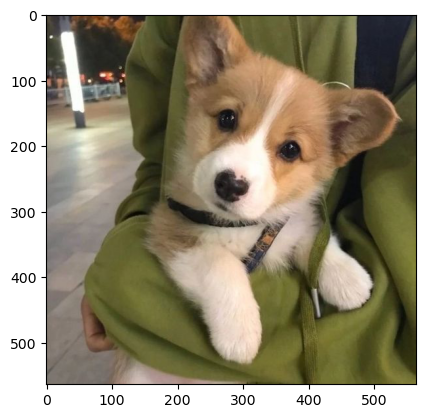

It's a dog!


In [99]:
show_image_and_label('img.png')

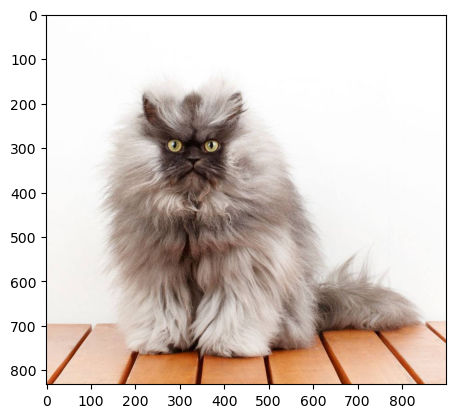

It's a cat!


In [105]:
show_image_and_label('img_2.png')

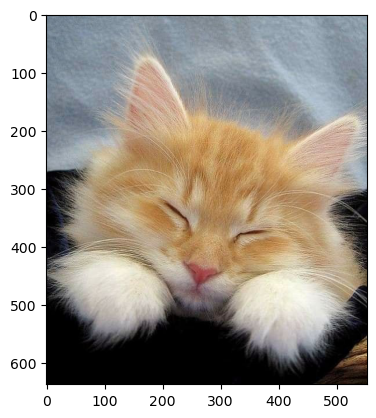

It's a cat!


In [100]:
show_image_and_label('img_3.png')

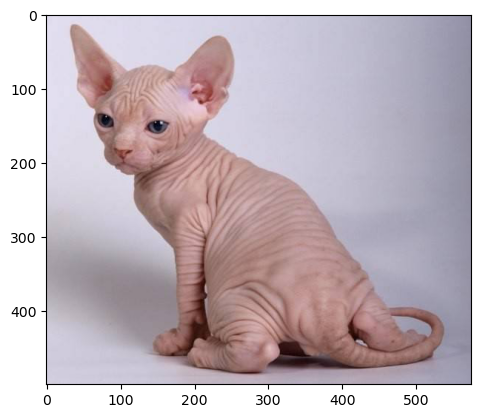

It's a cat!


In [106]:
show_image_and_label('img_4.png')

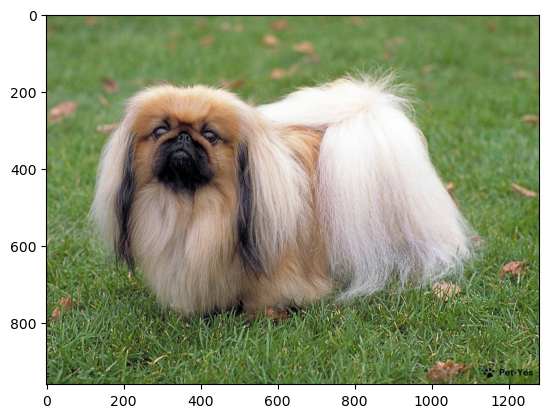

It's a dog!


In [107]:
show_image_and_label('img_5.png')